## 1. Introduction

## 2. Loading libraries and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from lifelines import KaplanMeierFitter


In [2]:
df = pd.read_csv('..\data\WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Data Overview

In [4]:
df.shape

(7043, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 4. Missing & Duplicate Values

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

In [8]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
tenure_zero = df[df['tenure'] == 0][['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']]
tenure_zero

,tenure,MonthlyCharges,TotalCharges,Churn
488,0,52.55,NaN,No
753,0,20.25,NaN,No
936,0,80.85,NaN,No
1082,0,25.75,NaN,No
1340,0,56.05,NaN,No
3331,0,19.85,NaN,No
3826,0,25.35,NaN,No
4380,0,20.00,NaN,No
5218,0,19.70,NaN,No
6670,0,73.35,NaN,No


In [10]:
df = df.drop(tenure_zero.index, axis=0)
df = df.reset_index(drop=True)

In [11]:
df.isna().sum().sum()

np.int64(0)

## 5. Exploratory Data Analysis

In [12]:
df["SeniorCitizen"]= df["SeniorCitizen"].map({0: "No", 1: "Yes"})

### Distributions

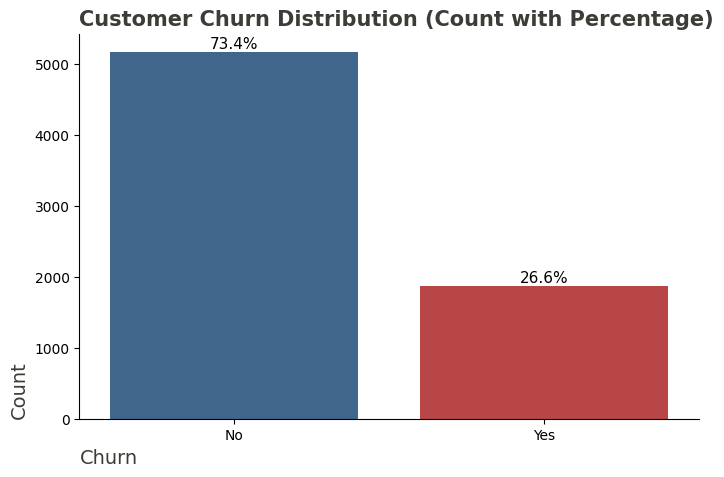

In [13]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(data=df, x='Churn', hue='Churn', palette=['#336699', '#CC3333'])

total = len(df) 
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2, height + 50, f'{percentage:.1f}%', ha='center', fontsize=11)

sns.despine(top=True, right=True)
ax.set_title(
    "Customer Churn Distribution (Count with Percentage)",
    weight="bold",
    color="#3C3D37",
    fontsize=15,
    loc="left",
)
ax.set_xlabel(
    "Churn",
    loc="left",
    fontsize=14,
    color="#3C3D37",
)
ax.set_ylabel(
    "Count",
    loc="bottom",
    fontsize=14,
    color="#3C3D37",
)
plt.show()


In [14]:
# function for plotting distributions

def plot_Distribution_by_Churn(col):
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=df, x=f'{col}', hue='Churn', palette=['#336699', '#CC3333'], legend=False)


    df_grouped = df.groupby([f'{col}', 'Churn']).size().reset_index(name='Count')
    df_total = df_grouped.groupby(f'{col}')['Count'].sum().reset_index(name='Total')
    for i, service in enumerate(df_total[f'{col}']):
        total_count = df_total[df_total[f'{col}'] == service]['Total'].values[0]
        ax.bar(service, total_count, color='gray', alpha=0.4, width=0.8, zorder=-1)
        total_percentage = (total_count / df[f'{col}'].value_counts().sum()) * 100
        ax.text(service, total_count + 50, f'{total_percentage:.0f}%', ha='center')


    grouped = df.groupby([f'{col}', 'Churn']).size().reset_index(name='count')
    total = grouped.groupby(f'{col}')['count'].transform('sum')
    grouped['percentage'] = 100 * grouped['count'] / total
    percentage_dict = grouped.set_index([f'{col}', 'Churn'])['percentage'].to_dict()
    x_labels = df[f'{col}'].unique()
    churn_labels = df['Churn'].unique()
    i = 0
    for churn in churn_labels:
        for l in x_labels:
            bar = ax.patches[i]
            height = bar.get_height()
            x = bar.get_x() + bar.get_width() / 2
            percent = percentage_dict.get((l, churn), None)
            if percent is not None:
                ax.text(x, height + 50, f'{percent:.0f}%', ha='center')
            i += 1


    ax.set_title(
        f"Distribution of {col} by Churn Status",
        weight="bold",
        color="#3C3D37",
        fontsize=15,
        loc="left",
    )
    ax.set_xlabel(
        f'{col}',
        loc="left",
        fontsize=14,
        color="#3C3D37",
    )
    ax.set_ylabel(
        "Count",
        loc="bottom",
        fontsize=14,
        color="#3C3D37",
    )
    sns.despine()
    plt.tight_layout()
    plt.show()


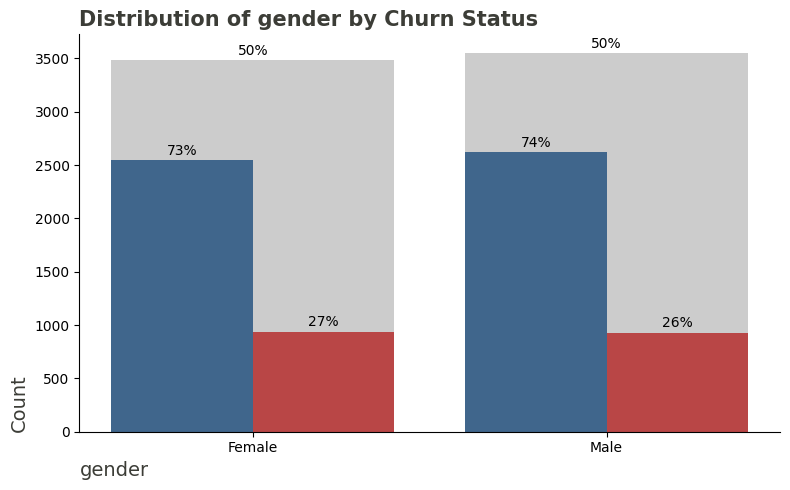

In [15]:
plot_Distribution_by_Churn('gender')

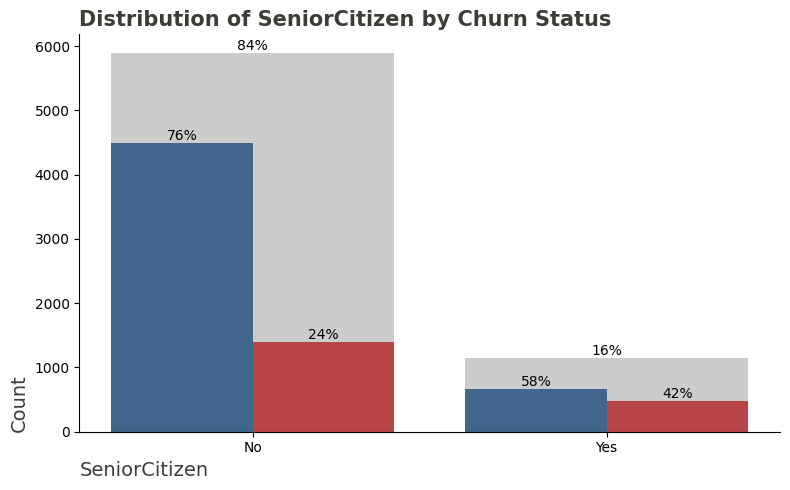

In [16]:
plot_Distribution_by_Churn('SeniorCitizen')

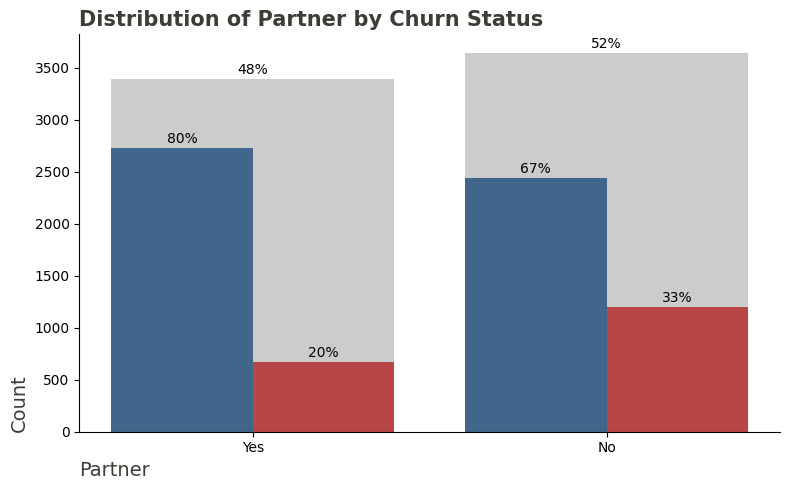

In [17]:
plot_Distribution_by_Churn('Partner')

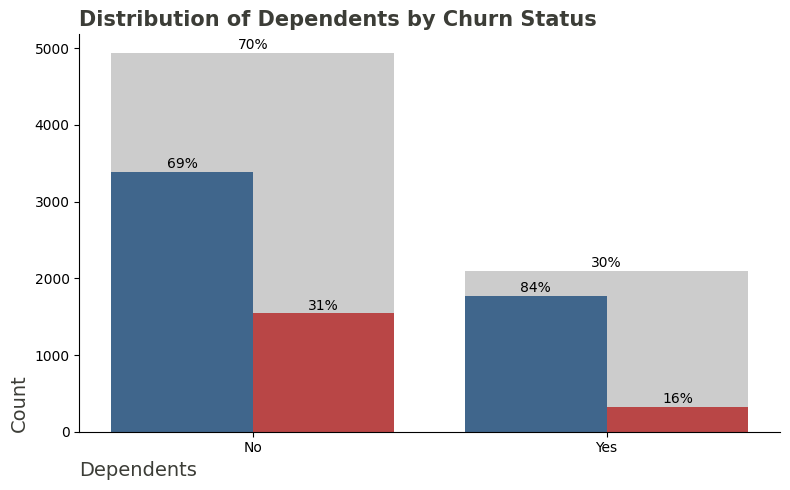

In [18]:
plot_Distribution_by_Churn('Dependents')

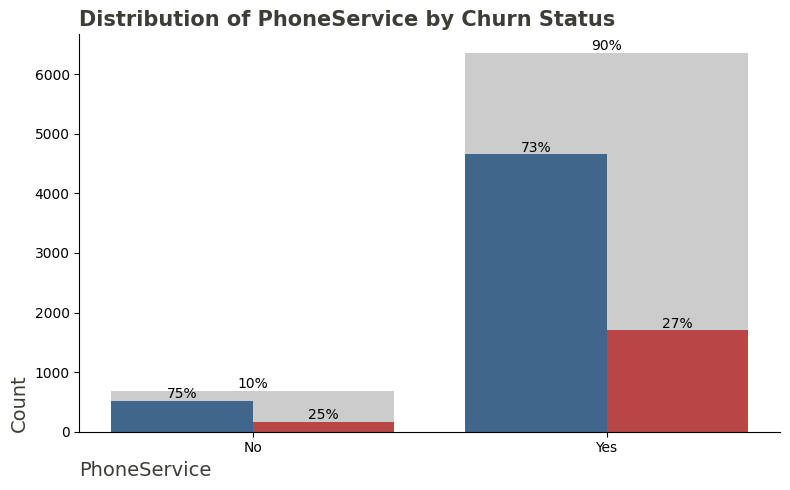

In [19]:
plot_Distribution_by_Churn('PhoneService')

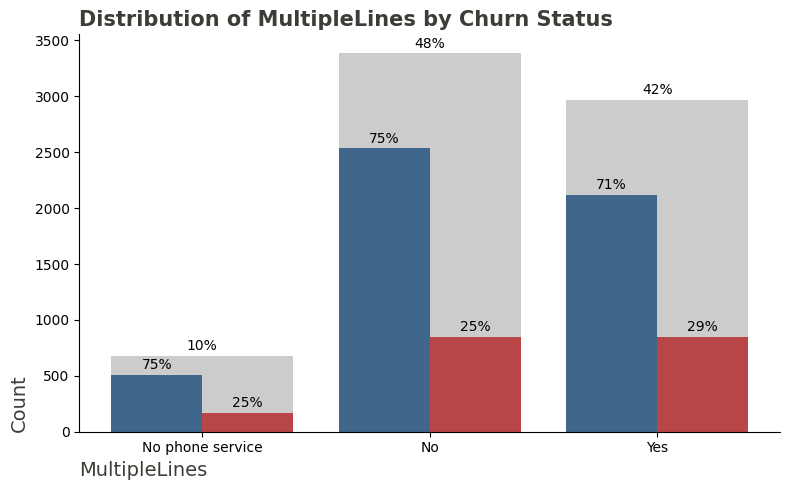

In [20]:
plot_Distribution_by_Churn('MultipleLines')

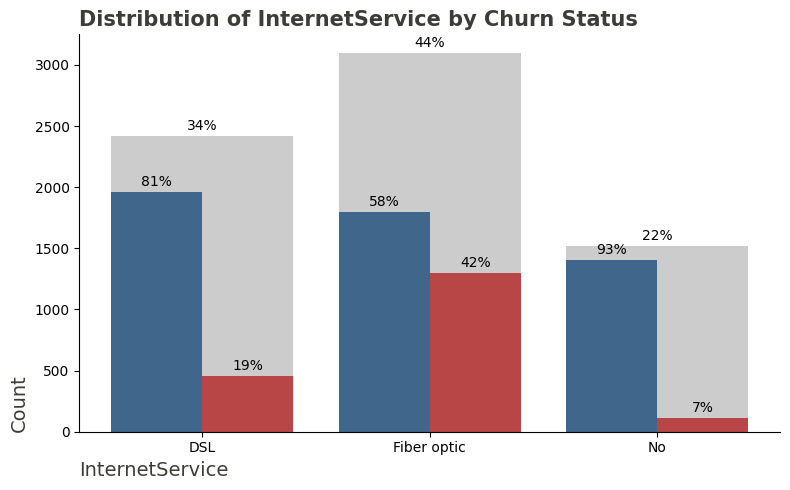

In [21]:
plot_Distribution_by_Churn('InternetService')

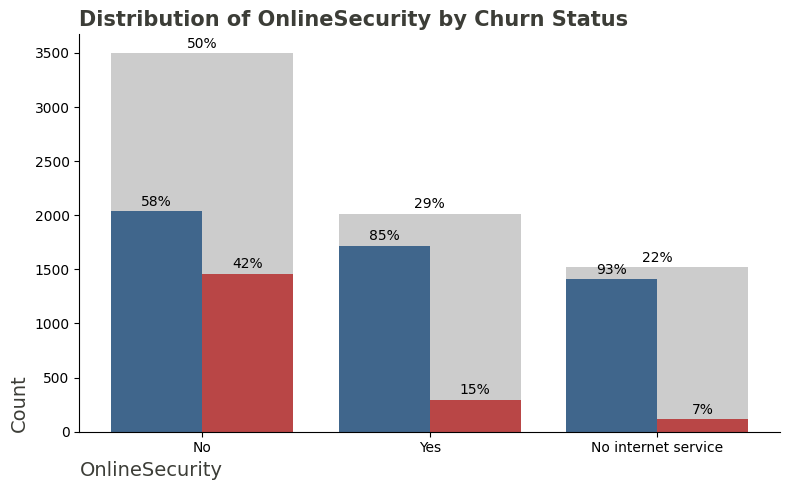

In [22]:
plot_Distribution_by_Churn('OnlineSecurity')

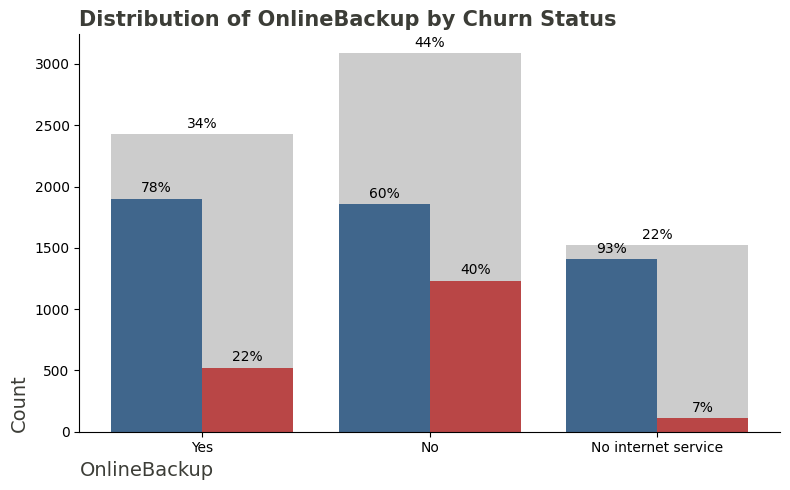

In [23]:
plot_Distribution_by_Churn('OnlineBackup')

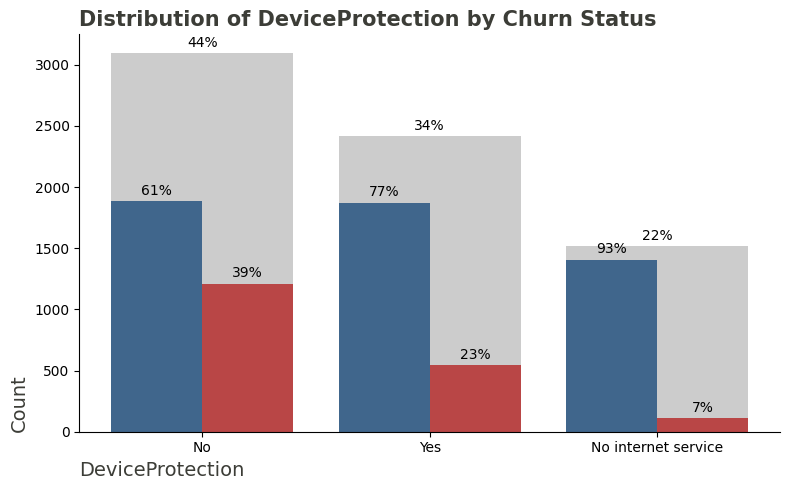

In [24]:
plot_Distribution_by_Churn('DeviceProtection')

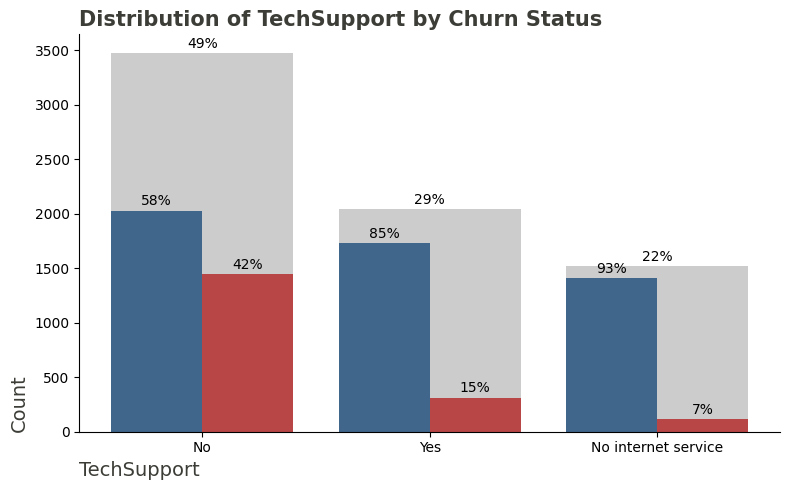

In [25]:
plot_Distribution_by_Churn('TechSupport')

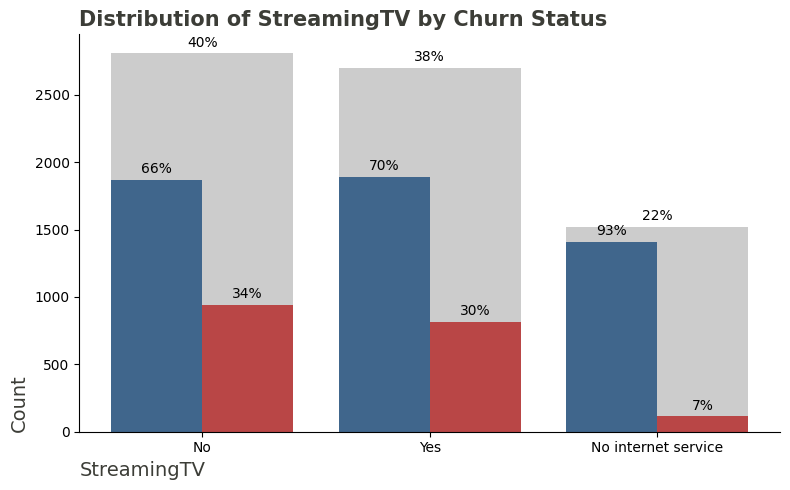

In [26]:
plot_Distribution_by_Churn('StreamingTV')

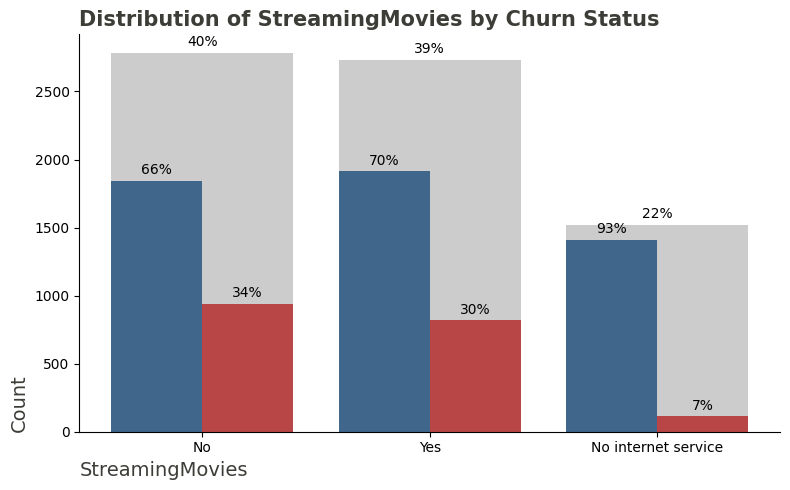

In [27]:
plot_Distribution_by_Churn('StreamingMovies')

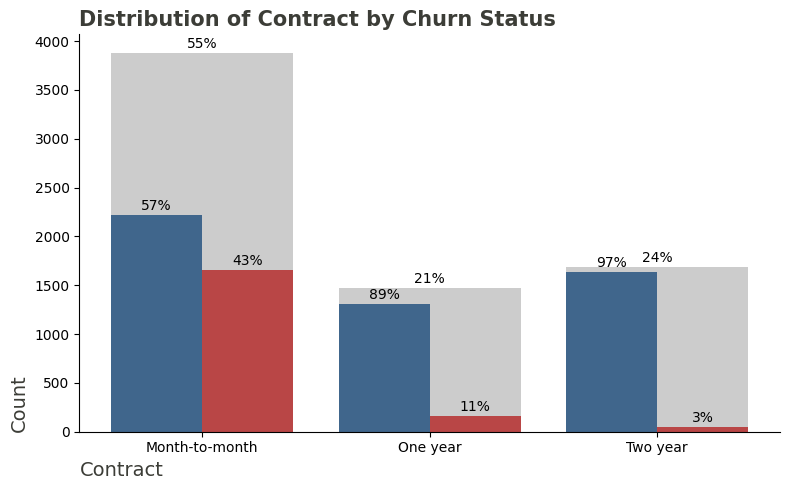

In [28]:
plot_Distribution_by_Churn('Contract')

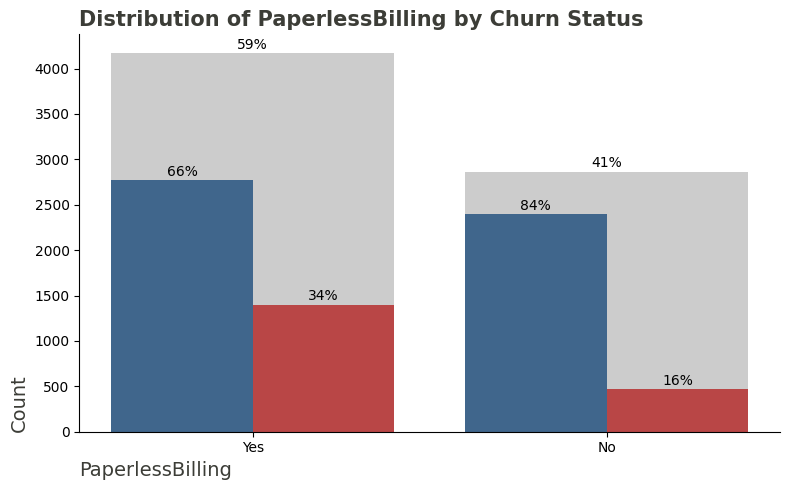

In [29]:
plot_Distribution_by_Churn('PaperlessBilling')

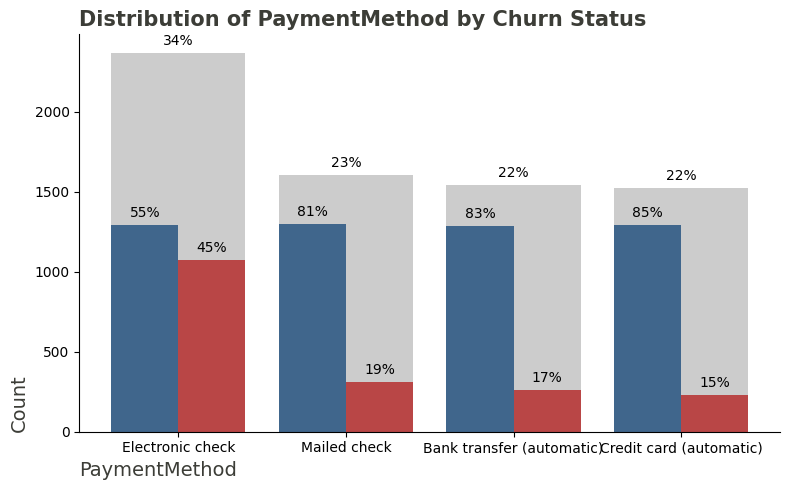

In [30]:
plot_Distribution_by_Churn('PaymentMethod')

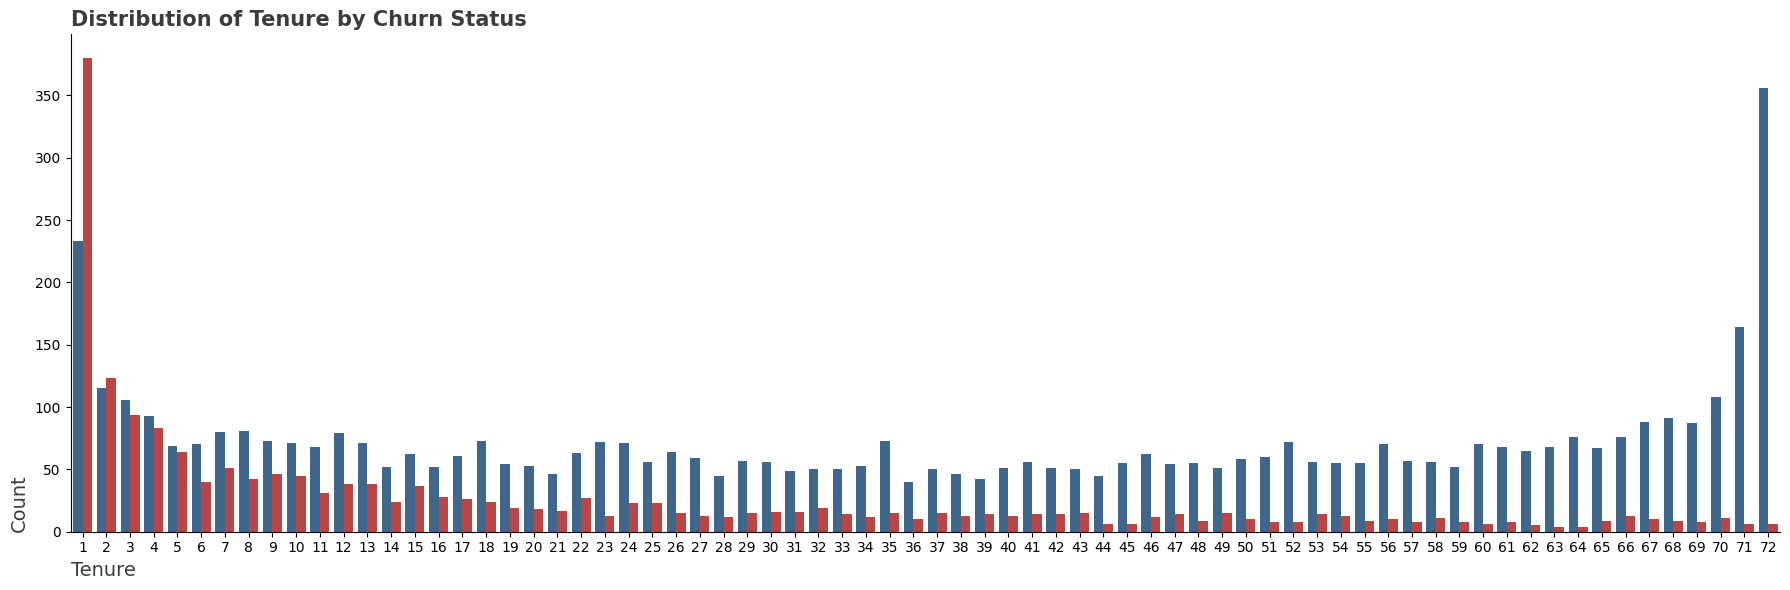

In [31]:
plt.figure(figsize=(18, 6))

ax = sns.barplot(data=df, x='tenure', y=df.groupby(['tenure', 'Churn'])['tenure'].transform('count'), hue='Churn', palette=['#336699', '#CC3333'], legend=False)

sns.despine(top=True, right=True)
ax.set_title(
        "Distribution of Tenure by Churn Status",
        weight="bold",
        color="#3C3D37",
        fontsize=15,
        loc="left",
    )
ax.set_xlabel(
        "Tenure",
        loc="left",
        fontsize=14,
        color="#3C3D37",
    )
ax.set_ylabel(
        "Count",
        loc="bottom",
        fontsize=14,
        color="#3C3D37",
    )
plt.tight_layout()
plt.show()


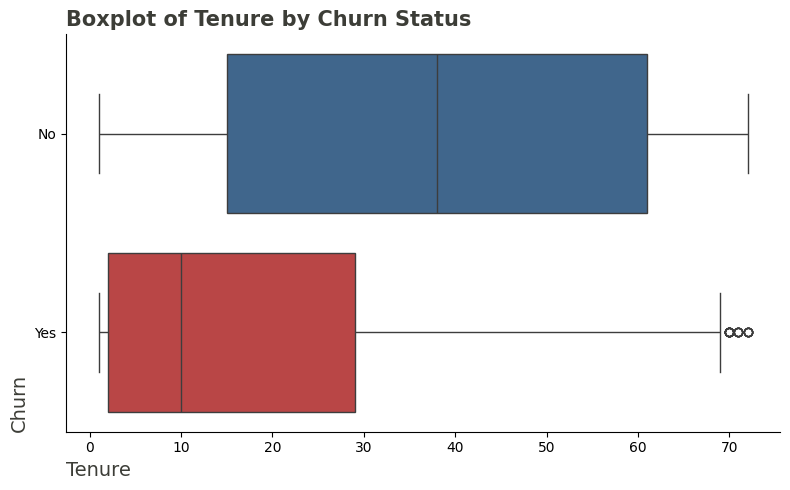

In [32]:
plt.figure(figsize=(8, 5))
ax = sns.boxplot(
    data=df,
    x='tenure',
    y='Churn',
    palette=['#336699', '#CC3333'],
    orient='h',
    hue='Churn',
    legend=False
)
sns.despine(top=True, right=True)
ax.set_title(
        "Boxplot of Tenure by Churn Status",
        weight="bold",
        color="#3C3D37",
        fontsize=15,
        loc="left",
    )
ax.set_xlabel(
        "Tenure",
        loc="left",
        fontsize=14,
        color="#3C3D37",
    )
ax.set_ylabel(
        "Churn",
        loc="bottom",
        fontsize=14,
        color="#3C3D37",
    )
plt.tight_layout()
plt.show()


In [33]:
df['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

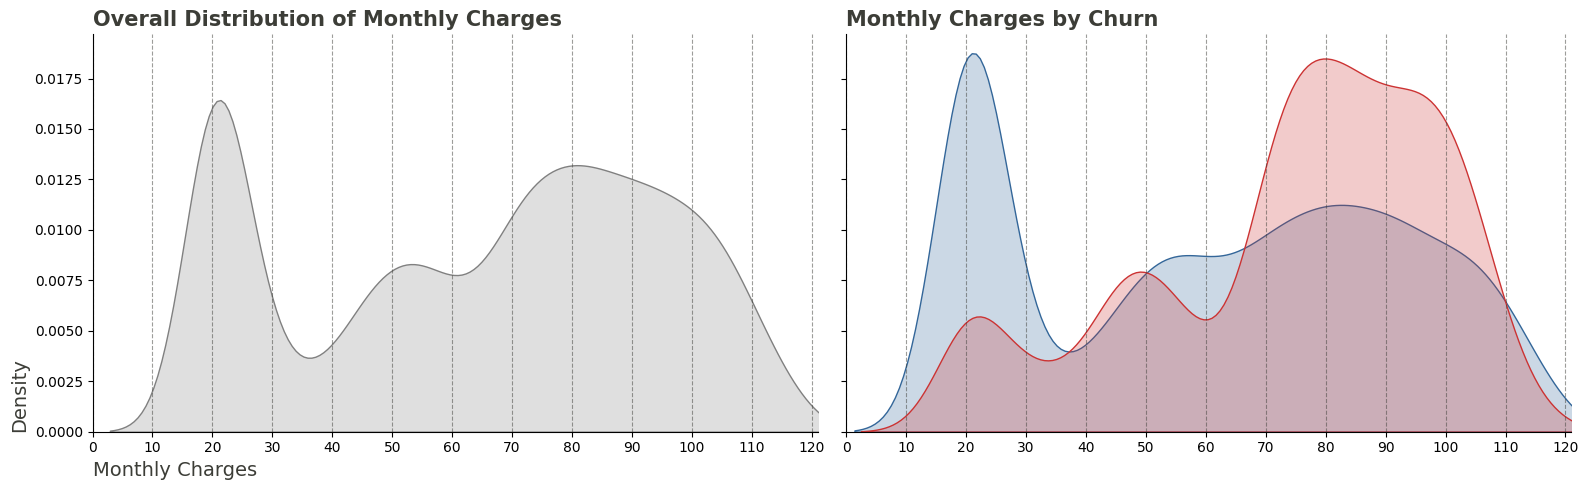

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

sns.kdeplot(df['MonthlyCharges'], color='gray', fill=True, ax=axes[0])
axes[0].set_title('Overall Distribution of Monthly Charges',
        weight="bold",
        color="#3C3D37",
        fontsize=15,
        loc="left")
axes[0].set_xlabel(
    "Monthly Charges",
    loc="left",
    fontsize=14,
    color="#3C3D37",
)
axes[0].set_ylabel(
        "Density",
        loc="bottom",
        fontsize=14,
        color="#3C3D37",
    )
axes[0].set_xlim(0, 121)
axes[0].set_xticks(range(0, 121, 10))
axes[0].grid(axis='x', linestyle='--', alpha=0.5, color= '#3C3D37')

sns.kdeplot(df[df["Churn"] == 'No']['MonthlyCharges'], color='#336699', fill=True, ax=axes[1])
sns.kdeplot(df[df["Churn"] == 'Yes']['MonthlyCharges'], color='#CC3333', fill=True, ax=axes[1])
axes[1].set_title('Monthly Charges by Churn',
        weight="bold",
        color="#3C3D37",
        fontsize=15,
        loc="left")
axes[1].set_xlim(0, 121)
axes[1].set_xticks(range(0, 121, 10))
axes[1].grid(axis='x', linestyle='--', alpha=0.5, color= '#3C3D37')
axes[1].set_xlabel('')




sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()


In [35]:
df['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

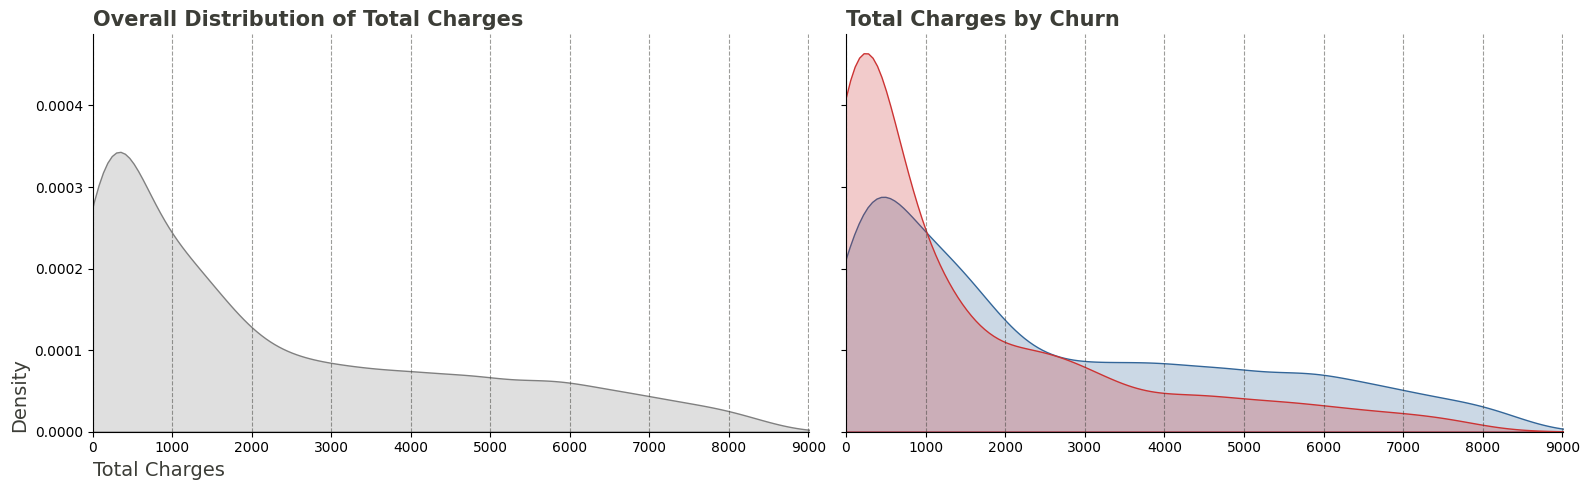

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

sns.kdeplot(df['TotalCharges'], color='gray', fill=True, ax=axes[0])
axes[0].set_title('Overall Distribution of Total Charges',
        weight="bold",
        color="#3C3D37",
        fontsize=15,
        loc="left")
axes[0].set_xlabel(
    "Total Charges",
    loc="left",
    fontsize=14,
    color="#3C3D37",
)
axes[0].set_ylabel(
        "Density",
        loc="bottom",
        fontsize=14,
        color="#3C3D37",
    )
axes[0].set_xlim(0, 9010)
axes[0].set_xticks(range(0, 9001, 1000))
axes[0].grid(axis='x', linestyle='--', alpha=0.5, color= '#3C3D37')

sns.kdeplot(df[df["Churn"] == 'No']['TotalCharges'], color='#336699', fill=True, ax=axes[1])
sns.kdeplot(df[df["Churn"] == 'Yes']['TotalCharges'], color='#CC3333', fill=True, ax=axes[1])
axes[1].set_title('Total Charges by Churn',
        weight="bold",
        color="#3C3D37",
        fontsize=15,
        loc="left")
axes[1].set_xlim(0, 9001)
axes[1].set_xticks(range(0, 9010, 1000))
axes[1].grid(axis='x', linestyle='--', alpha=0.5, color= '#3C3D37')
axes[1].set_xlabel('')



sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()


### Other Analysis

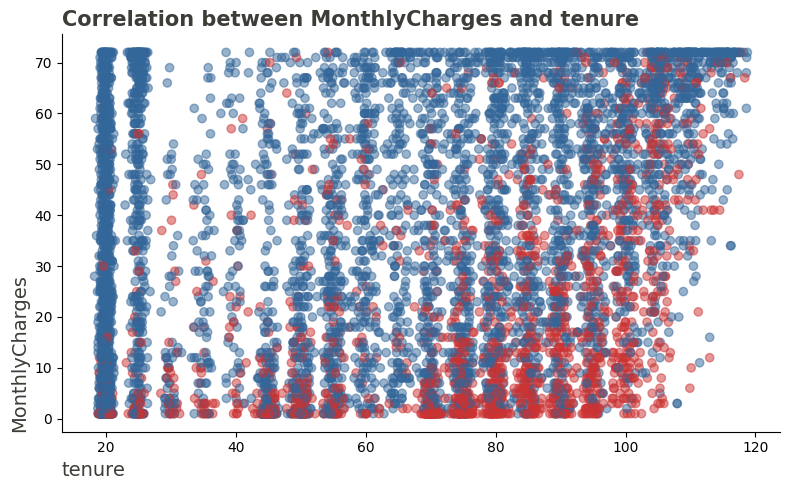

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))

colors = df['Churn'].apply(lambda x: '#336699' if x == 'No' else '#CC3333')
ax.scatter(df['MonthlyCharges'], df['tenure'], color=colors, alpha=0.5)  # کاهش شفافیت دایره‌ها

ax.set_title(
    "Correlation between MonthlyCharges and tenure",
    weight="bold",
    color="#3C3D37",
    fontsize=15,
    loc="left",
)
ax.set_xlabel(
    "tenure",
    loc="left",
    fontsize=14,
    color="#3C3D37",
)
ax.set_ylabel(
    "MonthlyCharges",
    loc="bottom",
    fontsize=14,
    color="#3C3D37",
)

ax.spines[["right", "top"]].set_visible(False)

plt.tight_layout()
plt.show()


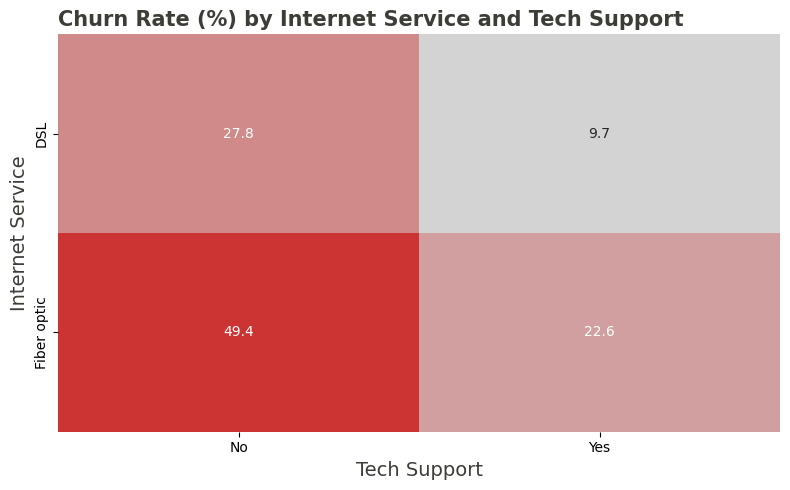

In [38]:
df_filtered = df[df['InternetService'] != 'No']

churn_pct = pd.crosstab(
    [df_filtered['InternetService'], df_filtered['TechSupport']],
    df_filtered['Churn'],
    normalize='index'
) * 100

churn_yes_pct = churn_pct['Yes'].unstack()

colors = ['#D3D3D3', '#CC3333']
cmap = LinearSegmentedColormap.from_list("custom_red_gray", colors)

plt.figure(figsize=(8, 5))
ax = sns.heatmap(churn_yes_pct, annot=True, fmt=".1f", cmap=cmap, cbar=False)


ax.set_title(
    "Churn Rate (%) by Internet Service and Tech Support",
    weight="bold",
    color="#3C3D37",
    fontsize=15,
    loc="left",
)
ax.set_xlabel(
    "Tech Support",
    fontsize=14,
    color="#3C3D37",
)
ax.set_ylabel(
    "Internet Service",
    fontsize=14,
    color="#3C3D37",
)
plt.tight_layout()
plt.show()


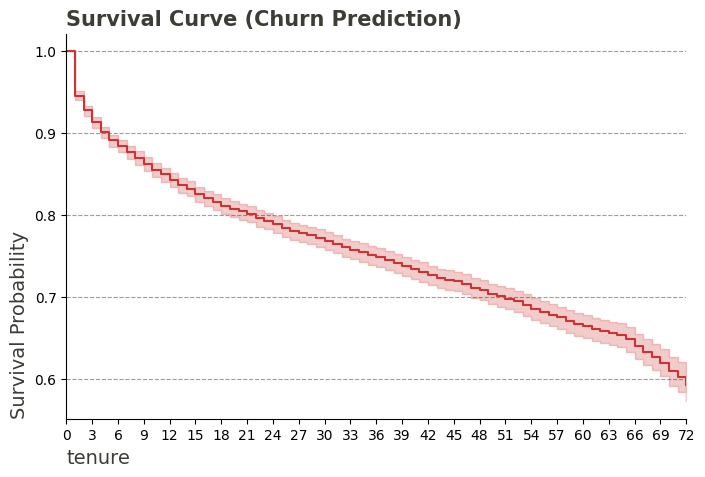

In [39]:
kmf = KaplanMeierFitter()

df_kmf = df[['Churn', 'tenure']].copy()
df_kmf.loc[:, 'tenure_num'] = pd.to_numeric(df_kmf['tenure'], errors='coerce')
df_kmf.loc[:, 'Churn_num'] = df_kmf['Churn'].map({'Yes': 1, 'No': 0})

kmf.fit(df_kmf['tenure_num'], event_observed=df_kmf['Churn_num'])

plt.figure(figsize=(8, 5))

ax = kmf.plot_survival_function(color='#CC3333', legend=False)

plt.xlim(0, 72) 
plt.xticks(range(0, 73, 3))
plt.grid(axis='y', linestyle='--', alpha=0.5, color= '#3C3D37')

ax.set_title(
    "Survival Curve (Churn Prediction)",
    weight="bold",
    color="#3C3D37",
    fontsize=15,
    loc="left",
)
ax.set_xlabel(
    "tenure",
    loc="left",
    fontsize=14,
    color="#3C3D37",
)
ax.set_ylabel(
    "Survival Probability",
    loc="bottom",
    fontsize=14,
    color="#3C3D37",
)

sns.despine(top=True, right=True)


plt.show()
